In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from pathlib import Path
import datetime

# 1. Data Exploration

Milling data is in the repo, but can also be downloaded from the [NASA Prognostics Center](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#milling). Extract the mill.zip.

In [2]:
data_folder = Path()  # mill.mat should be in the pwd
data_file = data_folder / 'mill.mat'

# load the data from the matlab file
m = sio.loadmat(data_file,struct_as_record=True)

# store the 'mill' data in a seperate np array
data = m['mill']

# store the field names in the data np array in a tuple, l
l = data.dtype.names

# create empty dataframe for the labels
df_labels = pd.DataFrame()

# get the labels from the original .mat file and put in dataframe
for i in range(7):
    # list for storing the label data for each field
    x = []
    
    # iterate through each of the unique cuts
    for j in range(167):
        x.append(data[0,j][i][0][0])
    x = np.array(x)
    df_labels[str(i)] = x

# add column names to the dataframe
df_labels.columns = l[0:7]
    
# create a column with the unique cut number
df_labels['cut_no'] = [i for i in range(167)]
df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no
0,1,1,0.00,2,1.5,0.5,1,0
1,1,2,NaN,4,1.5,0.5,1,1
2,1,3,NaN,6,1.5,0.5,1,2
3,1,4,0.11,7,1.5,0.5,1,3
4,1,5,NaN,11,1.5,0.5,1,4


There are 167 cuts in total. Each cut has six measurements being taken at a sampling rate of 250 Hz and 9000 sampling point. The six signals are:
- **smcAC**: AC spindle motor current
- **smcDC**: DC spindle motor current
- **vib_table**: Table vibration
- **vib_spindle**: Spindle vibration
- **AE_table**: Acoustic emission at table
- **AE_spindle**: Acoustic emission at spindle

In [3]:
# list of the six signals in each cut
l[7:]

('smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle')

There are 16 distinct cases, with a varying number of runs per case. The feed rate will be either 0.25 or 0.5 mm/rev for each case. See the Readme.pdf in the mill.zip file for more details.

Let's look at one of the cuts:

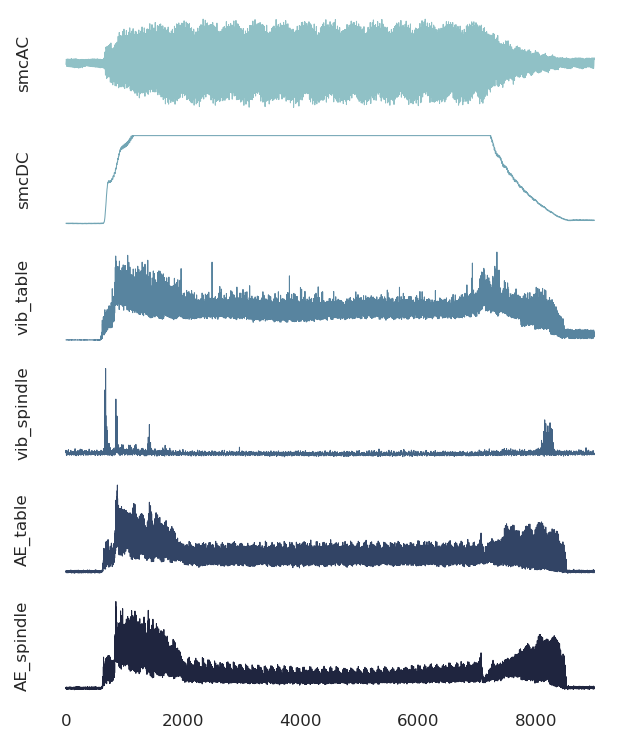

In [4]:
def plot_cut(cut_signal, signals_trend):
    
    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(6, rot=-.25, light=.7)
    sns.set(style="white", context="notebook")
    
    fig, axes = plt.subplots(6, 1,dpi=150, figsize=(5,6), sharex=True, constrained_layout=False,)

    # go through each of the signals
    for i in range(6):
        axes[i].plot(cut_signal[signals_trend[i]],color=pal[i],linewidth=0.5, alpha=1)
        axis_label = signals_trend[i]
        axes[i].set_ylabel(axis_label,fontsize=8)
        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
            axes[i].tick_params(axis="x", labelsize=8)
    
    plt.show()
    
signals_trend = l[7:] # there are 6 types of signals, smcAC to AE_spindle
cut_signal = data[0,166] 

plot_cut(cut_signal, signals_trend)

# 2. Data Prep

Add the state of the tool (similar to what is done here: https://ieeexplore.ieee.org/abstract/document/8681165 ):

**Healthy Sate** (label=0): 0-0.2mm flank wear <br/>
**Degredation State** (label=1): 0.2-0.7mm flank wear <br/>
**Failure State** (label=2): >0.7mm flank wear <br/>

In [5]:
def tool_state(cols):
    '''Add the label to the cut. Categories are:
    Healthy Sate (label=0): 0~0.2mm flank wear
    Degredation State (label=1): 0.2~0.7mm flank wear
    Failure State (label=2): >0.7mm flank wear 
    '''
    # pass in the tool wear, VB, column
    vb = cols
   
    if vb < 0.2:
        return 0
    elif vb >= 0.2 and vb < 0.7:
        return 1
    elif pd.isnull(vb):
        pass
    else:
        return 2

In [6]:
# apply the label to the dataframe
df_labels['tool_class'] = df_labels['VB'].apply(tool_state)

In [7]:
df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no,tool_class
0,1,1,0.00,2,1.5,0.5,1,0,0.0
1,1,2,NaN,4,1.5,0.5,1,1,NaN
2,1,3,NaN,6,1.5,0.5,1,2,NaN
3,1,4,0.11,7,1.5,0.5,1,3,0.0
4,1,5,NaN,11,1.5,0.5,1,4,NaN


We manually labelled the above table to fill in the NaN's in the tool_class. This was easier than automating it...

In [8]:
### UNCOMMENT TO SAVE CSV ###
# df_labels.to_csv('labels_with_tool_class.csv', index=False)

# load the labeled CSV (NaNs filled in by hand)
df_labels = pd.read_csv('labels_with_tool_class.csv')

df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no,tool_class
0,1,1,0.00,2,1.5,0.5,1,0,0
1,1,2,NaN,4,1.5,0.5,1,1,0
2,1,3,NaN,6,1.5,0.5,1,2,0
3,1,4,0.11,7,1.5,0.5,1,3,0
4,1,5,NaN,11,1.5,0.5,1,4,0


In [10]:
# check to see the categories we are going to trend
for i in l[7:]:
    print(i)

smcAC
smcDC
vib_table
vib_spindle
AE_table
AE_spindle


Now we scale the data between -1 and 1.

In [12]:
def scaler(x,min_val,max_val, lower_norm_val, upper_norm_val):
    """Scale the signal between a min and max value
    
    Parameters
    ===========
    x : ndarray
        Signal that is being normalized

    max_val : int or float
        Maximum value of the signal or dataset

    min_val : int or float
        Minimum value of the signal or dataset

    lower_norm_val : int or float
        Lower value you want to normalize the data between (e.g. 0)

    upper_norm_val : int or float
        Upper value you want to normalize the data between (e.g. 1)

    Returns
    ===========
    x : ndarray
        Returns a new array that was been scaled between the upper_norm_val
        and lower_norm_val values

    """
    
    # https://codereview.stackexchange.com/questions/185785/scale-numpy-array-to-certain-range
    col, row = np.shape(x)
    for i in range(col):
        x[i] = np.interp(x[i], (min_val, max_val), (lower_norm_val, upper_norm_val))
    return x

# get the min-max values for the smcAC and smcDC signals
def get_min_max(x):
    
    # flatten the input array http://bit.ly/2MQuXZd
    flat_vector = np.concatenate(x).ravel()
    
    min_val = min(flat_vector)
    max_val = max(flat_vector)
    
    return min_val, max_val

In [13]:
# iterate through each signal type in the data to scale
for i in l[7:]:
    list_a = [] # empty list
    print(i)
    
    # iterate through each data-point in the samples
    for j in range(167):
        a = data[0,j][i]

        # exclude some samples since they are bad
        if j not in [17, 94]:
            for k in get_min_max(a):
                list_a.append(k)
        else:
            pass
    
    # get min-max values
    min_val_a = min(list_a)
    max_val_a = max(list_a)
    print(min_val_a, max_val_a, '\n')
    
    # scale each sample
    for j in range(167):
        a = data[0,j][i]
        a = scaler(a,min_val_a, max_val_a, 0, 1)
    

smcAC
0.0 1.0 

smcDC
0.0 1.0 

vib_table
0.0 1.0 

vib_spindle
0.0 1.0 

AE_table
0.0 1.0 

AE_spindle
0.0 1.0 



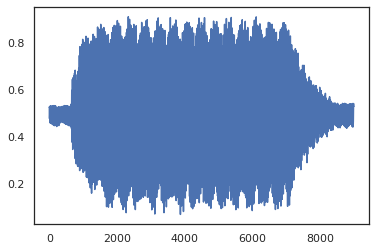

In [14]:
# plot a scaled data
plt.plot(data[0,166]['smcAC'])

In [17]:
df_test.head()

,case,run,VB,time,DOC,feed,material,cut_no,tool_class
61,10,1,0.00,0,1.5,0.25,1,61,0
62,10,2,0.04,4,1.5,0.25,1,62,0
63,10,3,0.08,9,1.5,0.25,1,63,0
64,10,4,0.16,15,1.5,0.25,1,64,0
65,10,5,0.25,21,1.5,0.25,1,65,1


## Create Train, Validation, Test Data Sets

We have some functions to creat tensors of the data, return the data in an X-Y format, and remove certain classes from the data sets to get a set of data suitable for anomaly detection

In [21]:
def create_tensor(data_sample, signal_names, start, end, window_size):
    '''Create a tensor from a cut sample. Final tensor will have shape: 
       [# samples, # sample len, # features/sample]
    
    Parameters
    ===========
    data_sample : ndarray
        single data sample containing all the signals
    
    signal_names : tuple
        tuple of all the signals that will be added into the tensor
    '''
    
    s = signal_names[::-1] # only include the six signals, and reverse order
    c = data_sample[s[0]].reshape((9000,1))

    for i in range(len(s)):
        try:
            a = data_sample[s[i+1]].reshape((9000,1)) # reshape to make sure
            c = np.hstack((a,c)) # horizontal stack
        except:
            # reshape into [# samples, # sample len, # features/sample]
            c = c[start:end]
            c = np.reshape(c, (1, c.shape[0],-1))
    
    # split the data
    no_splits = int((end - start) / window_size)
    c = np.vstack(np.split(c, no_splits, axis=1))
            
    return c

def return_xy(df_labels, data, signal_names, start, end, window_size):
    
    temp_cuts = [] # temporary list to hold all the windowed cuts
    temp_labels = []
    X = [] # instantiate X's
    y = [] # instantiate y's

    #iterate throught the df
    for i in df_labels.itertuples():
        cut_data_ind = create_tensor(data[0,i.cut_no], signal_names, start, end, window_size)
        temp_cuts.append(cut_data_ind)
        temp_labels.append(i.tool_class)
        

    for i, tool_class in enumerate(temp_labels):
        for cut_split in temp_cuts[i]:
            y.append(tool_class)
            X.append(cut_split)
            
    # vertical stack the X list (make it into an array)
    X = np.array(X)
    print('Shape of X:', X.shape)
    y = np.array(y)
    print('Shape of y:', y.shape)
    return X, y

def remove_classes(class_to_remove, y_val_slim, X_val_slim):
    """Funciton to remove classes from train/val set"""
    
    # start with y_valid_slim
    index_to_delete = []
    for i, class_digit in enumerate(y_val_slim):
        if class_digit in class_to_remove:
            index_to_delete.append(i)

    y_val_slim = np.delete(y_val_slim, index_to_delete)
    X_val_slim = np.delete(X_val_slim, index_to_delete, axis=0)
    
    return X_val_slim, y_val_slim

In [ ]:
# discard certain cuts as they are strange
cuts_remove = [17, 94]
df_labels.drop(cuts_remove, inplace=True)

We want to ensure that we have a complete life of tool in test data (tool_class from 0 to 2). Need to have the same for validation set.

- case 15 (0.5 feed rate), 10 (0.25 feed rate), 5 (0.25 feed rate) in test data
- case 11 (0.25 feed rate), 16 (0.5 feed rate) in validation data
- rest in training data

In [ ]:
# split the df_labels into the various train, validation, test sets
val_cases = [11, 13]
test_cases = [5,10,15]
train_cases = []

# there are 16 cases total
for i in range(1,17):
    if i in val_cases or i in test_cases:
        pass
    else:
        train_cases.append(i)

# create the label dataframes for each of the train, val, test sets
df_train = df_labels[df_labels['case'].isin(train_cases)]
df_val = df_labels[df_labels['case'].isin(val_cases)]
df_test = df_labels[df_labels['case'].isin(test_cases)]

In [22]:
signal_names = l[7:]
start = 960
end = 8000
window_size = 64


X_train, y_train = return_xy(df_train, data, signal_names, start, end, window_size)
X_val, y_val = return_xy(df_val, data, signal_names, start, end, window_size)
X_test, y_test = return_xy(df_test, data, signal_names, start, end, window_size)

X_train_slim, y_train_slim = remove_classes([2], y_train, X_train)
print('Shape of X_train_slim:', X_train_slim.shape)
print('Shape of y_train_slim:', y_train_slim.shape)
X_val_slim, y_val_slim = remove_classes([2], y_val, X_val)
print('Shape of X_val_slim:', X_val_slim.shape)
print('Shape of y_val_slim:', y_val_slim.shape)

Shape of X: (11440, 64, 6)
Shape of y: (11440,)
Shape of X: (4180, 64, 6)
Shape of y: (4180,)
Shape of X: (2530, 64, 6)
Shape of y: (2530,)
Shape of X_train_slim: (11110, 64, 6)
Shape of y_train_slim: (11110,)
Shape of X_val_slim: (3520, 64, 6)
Shape of y_val_slim: (3520,)


# 3 - Build Model

**How is an autoencoder used in anomaly detection?** <br/>
We will be building an convolutional autoencoder (CAE) to learn what a "normal" cutting signal looks like. We will then use the model to reconstruct cut signals and measure their reconstruction error. Anomolous signals should have a larger reconstruction error.

**What is an autoencoder?**
An autoencoder learns to copy its inputs to its output. It consists of an encoder section, and a decoder section. The data is often "squeezed" through a bottle neck (or a regularization technique is used) to get a lower dimensional representation of the data. This 

![autoencoder_schema](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Autoencoder_schema.png/659px-Autoencoder_schema.png)

**More Resources:** <br/>
"[Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.ca/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=sr_1_1?crid=22QX9UK796YMX&keywords=hands+on+machine+learning+with+scikit+learn+and+tensorflow&qid=1573668803&sprefix=hands+on+mac%2Caps%2C161&sr=8-1)" by Aurélien Geron is an excellent, and practical, resource for learning ML, sk-learn, and Tensorflow 2.0.

![title](https://i.imgur.com/02K74an.jpg)

**Setup Model Architecture**

Shuffle the data, just to be sure.

In [24]:
from sklearn.utils import shuffle

X_train_slim, y_train_slim = shuffle(X_train_slim, y_train_slim, random_state=0)
X_val_slim, y_val_slim = shuffle(X_val_slim, y_val_slim, random_state=0)
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [25]:
import tensorflow as tf
from tensorflow import keras
import tensorboard

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


In [25]:
# build a CAE
# code modified from Aurélien Geron 
# https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

tf.random.set_seed(15)
np.random.seed(15)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([64,6], input_shape=[64,6]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=5, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(256, kernel_size=3, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(512, kernel_size=3, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(pool_size=2),   
])

conv_decoder = keras.models.Sequential([
    keras.layers.UpSampling1D(size=2, input_shape=[8, 512]),
    keras.layers.Conv1D(256, kernel_size=3, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.UpSampling1D(size=2),
    keras.layers.Conv1D(128, kernel_size=5, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.UpSampling1D(size=2),
    keras.layers.Conv1D(6, kernel_size=2, padding='same', activation="selu"),
    keras.layers.Reshape([64, 6])
])

conv_ae = keras.models.Sequential([conv_encoder,conv_decoder])

# MSE and accuracy
conv_ae.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(),metrics=['mean_absolute_error'])

# show the model summaries
conv_encoder.summary()
conv_decoder.summary()

# use tensorboard to track training
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0,
                                                      update_freq='epoch',profile_batch=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 6)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6)             24        
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 128)           3968      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 128)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 256)           98560     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 256)           1

**Train Model**

In [26]:
history = conv_ae.fit(X_train_slim, X_train_slim, epochs=5,
                      validation_data=[X_val_slim, X_val_slim],callbacks=[tensorboard_callback])

Train on 11110 samples, validate on 3520 samples
Epoch 1/5
11110/11110 [==============================] - 8s 752us/sample - loss: 0.0694 - mean_absolute_error: 0.1185 - val_loss: 0.0042 - val_mean_absolute_error: 0.0539
Epoch 2/5
11110/11110 [==============================] - 4s 394us/sample - loss: 0.0032 - mean_absolute_error: 0.0432 - val_loss: 0.0041 - val_mean_absolute_error: 0.0501
Epoch 3/5
11110/11110 [==============================] - 4s 401us/sample - loss: 0.0027 - mean_absolute_error: 0.0397 - val_loss: 0.0024 - val_mean_absolute_error: 0.0370
Epoch 4/5
11110/11110 [==============================] - 4s 396us/sample - loss: 0.0024 - mean_absolute_error: 0.0371 - val_loss: 0.0022 - val_mean_absolute_error: 0.0382
Epoch 5/5
11110/11110 [==============================] - 5s 405us/sample - loss: 0.0024 - mean_absolute_error: 0.0367 - val_loss: 0.0015 - val_mean_absolute_error: 0.0313


**Visualize Results** <br/>
We now want to visualize some of the results. We will take the encoder portion and look at the latent variables that it generates. To do that, we will use t-SNE (t-Distributed Stochastic Neighbor Embedding) by [van der Maaten](https://lvdmaaten.github.io/tsne/). Of course, sklearn has a good [implementation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 

In [28]:
# use T-SNE
# code modified from https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

from sklearn.manifold import TSNE

def encoded_2d_tsne(X_valid_encoded):
    """Returns 2D representation of the latent space via T-SNE"""
        
    np.random.seed(63)
    tsne = TSNE()
    X_valid_2D = tsne.fit_transform(X_valid_encoded[:,:])
    X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
    return X_valid_2D

def plot_2d_ae(X_valid_2D, y_valid):
    fig, axes = plt.subplots(nrows=1,ncols=1,dpi=150)

    scatter = axes.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 
                            c=y_valid, s=3, 
                            cmap="Set1", 
                            alpha=0.5, 
                            linewidths=0, 
                            edgecolors=None,label=y_valid)

    # use legend elements to add legend http://bit.ly/2Pe77WK
    legend1 = axes.legend(*scatter.legend_elements(),
                        loc='best',frameon=False)
    
    legend1.get_frame().set_facecolor('none')
    axes.axis('off')
    plt.show()   

In [108]:
# get the 2D embeddings
conv_encoder_latent = conv_encoder(X_val)
conv_encoder_latent_avg = keras.layers.GlobalAveragePooling1D()(conv_encoder_latent).numpy()

X_valid_2D = encoded_2d_tsne(conv_encoder_latent_avg)

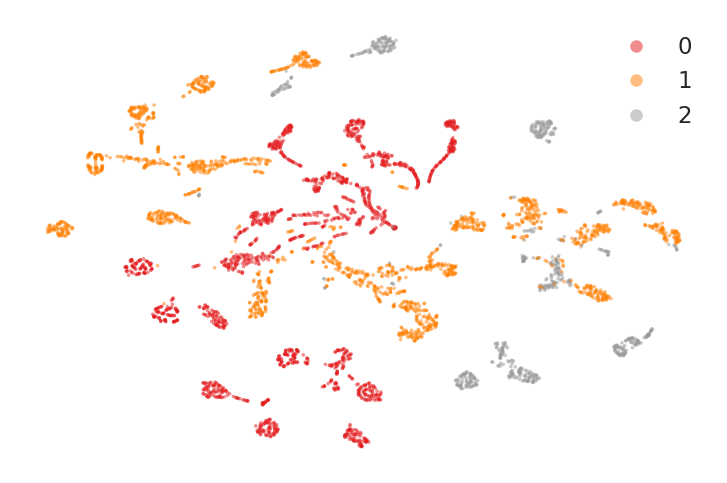

In [109]:
plot_2d_ae(X_valid_2D, y_val)

**Reconstruction error**

In [73]:
# build a table with all the RMSE results from the reconstructions
# sewar is a package that has many image quality assement algos already developed,
# and it can be used as a good guide https://github.com/andrewekhalel/sewar
# However, we will calculate the RMSE across the whole numpy array and then
# put these in a pandas dataframe

def mse(X_val,recon_val):
    """Calculate MSE for images in X_val and recon_val"""
    
    # need to calculate mean across the rows, and then across the columns
    return np.mean(np.mean(np.square(X_val.astype('float32') - recon_val.astype('float32')),axis=1),axis=1)

def rmse(X_val,recon_val):
    """Calculate RMSE for images in X_val and recon_val"""
    return np.sqrt(mse(X_val, recon_val))

def euclidean_distance(X_val,recon_val):
    dist = np.linalg.norm(X_val - recon_val,axis=(1,2))
    return dist

# function that creates a pandas dataframe with the RMSE value, and the associated class
def create_df_reconstruction(rmse_val, y_val, metric, class_to_remove, threshold_val):
    df = pd.DataFrame(data=rmse_val, columns=[metric])
    
    # append the class values
    df['class'] = y_val
    
    # label anomolous (outlier) data as -1, inliers as 1
        # -1 (outlier) is POSITIVE class
        #  1 (inlier) is NEGATIVE class
    new_y_val = []
    for i in y_val:
        if i in class_to_remove:
            new_y_val.append(-1)
        else:
            new_y_val.append(1)
    
    df['true_class'] = new_y_val
    
    # add prediction based on threshold
    df['prediction'] = np.where(df[metric] >= threshold_val,-1,1)
    
    return df

### Compare the Different Reconstruction Error Methods
Use MSE, RMSE, euclidean distance, and see which one gives the best results.

**MSE:**

In [132]:
# get the reconstructions on the X_val_slim dataset, and the X_val dataset
recon_val_slim = conv_ae(X_val_slim).numpy()
recon_val = conv_ae(X_val).numpy()

# calculate MSE reconstruction error
mse_recon_val_slim = mse(X_val_slim, recon_val_slim) # for slim dataset
mse_recon_val = mse(X_val, recon_val) # for complete validation dataset

# class to remove (for df creation)
class_to_remove = np.array([2],dtype='uint8')

In [133]:
# look at the maximum reconstruction error, and the 90th percentile
print(np.max(mse_recon_val_slim))
print(np.percentile(mse_recon_val_slim,90))

0.0055369386
0.00248399677220732


Best threshold value: 0.0013000000000000002 	ROC score: 55.31%

True Positive: 402
False Positive: 1770
True Negative: 1750
False Negative: 258

Confusion Matix:
[[ 402  258]
 [1770 1750]]


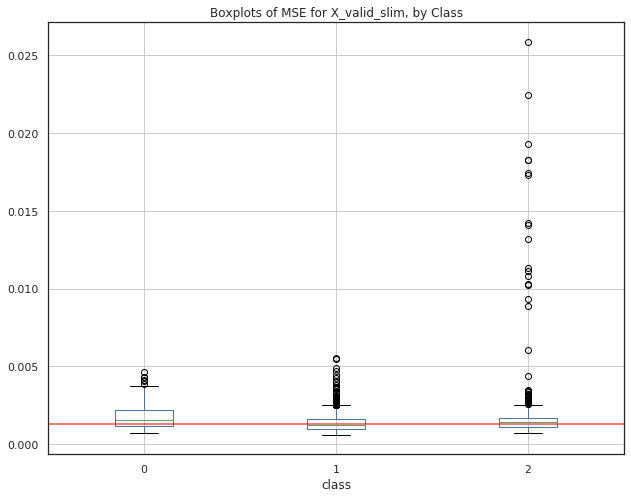

In [140]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve


roc_scores = {}
# for i in np.arange(0.1, 150, 0.5):
for i in np.arange(0.0001, 0.2, 0.0001):
     
    threshold_val = i
    df = create_df_reconstruction(mse_recon_val, y_val, "recon_metric",class_to_remove, threshold_val)
    roc_val = roc_auc_score(df['true_class'], df['prediction'])
    roc_scores[i] = roc_val

# return best roc_score and the threshold used to set it
threshold_val = max(zip(roc_scores.values(), roc_scores.keys()))
print('Best threshold value:', threshold_val[1],'\tROC score: {:.2%}'.format(threshold_val[0]))

# use the best threshold value to make a confusion matrix
df = create_df_reconstruction(mse_recon_val, y_val, "recon_metric",class_to_remove, threshold_val[1])


# True Positive
print("\nTrue Positive:",len(df[(df['true_class']==-1) & (df['prediction']==-1)]))
# False Positive -- predict anomaly (-1), when it is actually normal (1)
print("False Positive:",len(df[(df['true_class']==1) & (df['prediction']==-1)]))
# True Negative
print("True Negative:",len(df[(df['true_class']==1) & (df['prediction']==1)]))
#False Negative
print("False Negative:",len(df[(df['true_class']==-1) & (df['prediction']==1)]))

print('\nConfusion Matrix:')
print(confusion_matrix(df['true_class'], df['prediction']))

fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['recon_metric'], by='class', ax=ax).axhline(y=threshold_val[1],c='red',alpha=0.7)
plt.title('Boxplots of MSE for X_valid_slim, by Class')
plt.suptitle('')
plt.show()

![title](https://i.imgur.com/MEfumof.png)

In [135]:
#*#*# Positive class is -1
#*#*# Negative class is 1

# True Positive
print("True Positive:",len(df[(df['true_class']==-1) & (df['prediction']==-1)]))
# False Positive -- predict anomaly (-1), when it is actually normal (1)
print("False Positive:",len(df[(df['true_class']==1) & (df['prediction']==-1)]))
# True Negative
print("True Negative:",len(df[(df['true_class']==1) & (df['prediction']==1)]))
#False Negative
print("False Negative:",len(df[(df['true_class']==-1) & (df['prediction']==1)]))


True Positive: 402
False Positive: 1770
True Negative: 1750
False Negative: 258


(0, 0.01)

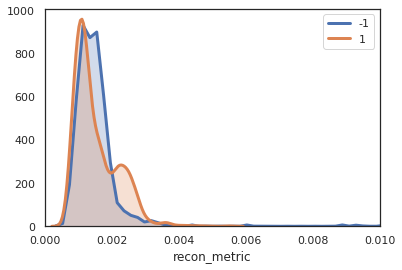

In [138]:
# examples of dist plots https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
import seaborn as sns

class_list = [-1,1]
for i in class_list:
    subset = df[df['true_class'] == i]
    
    sns.distplot(subset['recon_metric'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = i)

plt.xlim(0,0.01)
# plt.yscale("log")

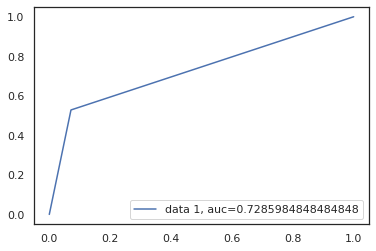

In [90]:
fpr, tpr, thresholds = roc_curve(df['new_class'],df['prediction'], pos_label=1)
auc = roc_auc_score(df['new_class'],df['prediction'])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [91]:
# try on test data
threshold_val = threshold_val[1]

# use test data
recon_test = conv_ae(X_test).numpy()

# calculate MSE reconstruction error
mse_recon_test = mse(X_test, recon_test) # for complete validation dataset

df = create_df_reconstruction(mse_recon_test, y_test, "recon_metric",class_to_remove, threshold_val)
roc_val = roc_auc_score(df['new_class'], df['prediction'])

print('Threshold value:', threshold_val,'\tROC score: {:.2%}'.format(roc_val))
print(confusion_matrix(df['new_class'], df['prediction']))

Threshold value: 0.0008 	ROC score: 63.55%
[[ 330    0]
 [1604  596]]


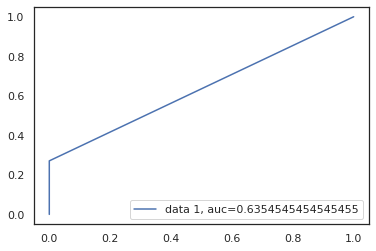

In [92]:
fpr, tpr, thresholds = roc_curve(df['new_class'],df['prediction'], pos_label=1)
auc = roc_auc_score(df['new_class'],df['prediction'])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**RMSE:**

In [93]:
# calculate RMSE reconstruction error
rmse_recon_val_slim = rmse(X_val_slim, recon_val_slim) # for slim dataset
rmse_recon_val = rmse(X_val, recon_val) # for complete validation dataset

# look at the maximum reconstruction error, and the 90th percentile
print(np.max(rmse_recon_val_slim))
print(np.percentile(rmse_recon_val_slim,90))

0.07186213
0.04321268126368522


Best threshold value: 0.028999999999999984 	ROC score: 73.39%

Confusion Matix:
[[ 585   75]
 [1473 2047]]


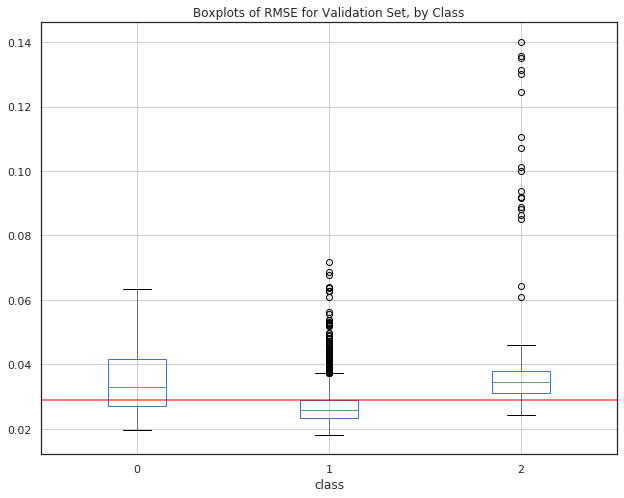

In [96]:
roc_scores = {}
for i in np.arange(0.01, 1.0, 0.001):
     
    threshold_val = i
    df = create_df_reconstruction(rmse_recon_val, y_val, "recon_metric",class_to_remove, threshold_val)
    roc_val = roc_auc_score(df['new_class'], df['prediction'])
    roc_scores[i] = roc_val

# return best roc_score and the threshold used to set it
threshold_val = max(zip(roc_scores.values(), roc_scores.keys()))
print('Best threshold value:', threshold_val[1],'\tROC score: {:.2%}'.format(threshold_val[0]))

# use the best threshold value to make a confusion matrix
df = create_df_reconstruction(rmse_recon_val, y_val, "recon_metric",class_to_remove, threshold_val[1])

print('\nConfusion Matix:')
print(confusion_matrix(df['new_class'], df['prediction']))

fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['recon_metric'], by='class', ax=ax).axhline(y=threshold_val[1],c='red',alpha=0.7)
plt.title('Boxplots of RMSE for Validation Set, by Class')
plt.suptitle('')
plt.show()

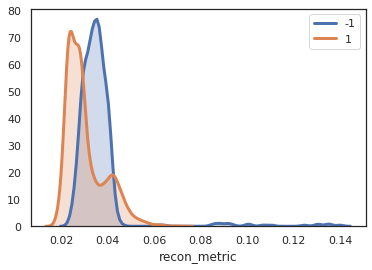

In [95]:
# examples of dist plots https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
import seaborn as sns

class_list = [-1,1]
for i in class_list:
    subset = df[df['new_class'] == i]
    
    sns.distplot(subset['recon_metric'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = i)

# plt.xlim(0,0.01)

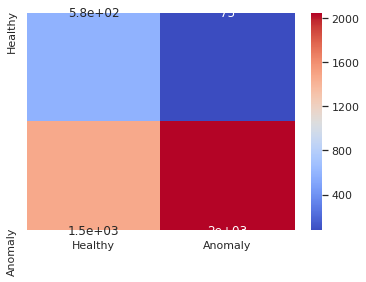

In [107]:
cm = confusion_matrix(df['new_class'], df['prediction'])

df_cm = pd.DataFrame(confusion_matrix(df['new_class'], df['prediction']),
                     index=['Healthy', 'Anomaly'],columns=['Healthy','Anomaly'])

sns.heatmap(df_cm,cmap='coolwarm',annot=True)

# fig = plt.figure()
# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
# res = sns.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f', cmap=cmap)
# res.invert_yaxis()

# plt.yticks([0.5,1.5,2.5], [ 'Dog', 'Cat', 'Rabbit'],va='center')
# plt.show()

In [101]:
df_cm

,Healthy,Anomaly
Healthy,585,75
Anomaly,1473,2047


**Euclidean Distance:**

In [346]:
# calculate RMSE reconstruction error
eu_recon_val_slim = euclidean_distance(X_val_slim, recon_val_slim) # for slim dataset
eu_recon_val = euclidean_distance(X_val, recon_val) # for complete validation dataset

# look at the maximum reconstruction error, and the 90th percentile
print(np.max(eu_recon_val_slim))
print(np.percentile(eu_recon_val_slim,90))

1.0064597795544936
0.5964445552641744


Best threshold value: 0.55 	ROC score: 82.52%

Confusion Matix:
[[ 539  121]
 [ 585 2935]]


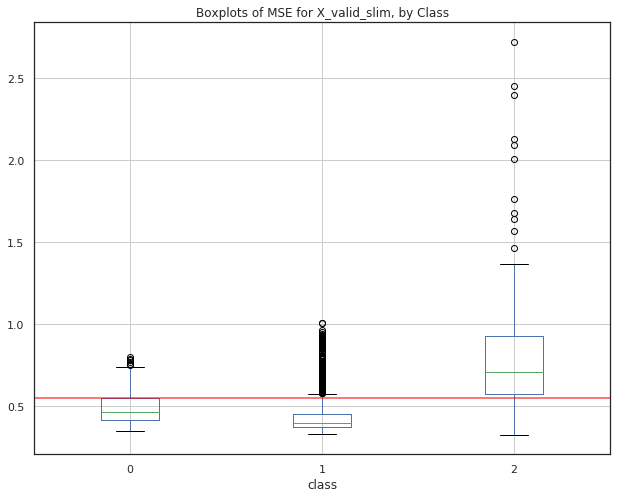

In [347]:
roc_scores = {}
for i in np.arange(0.01, 3, 0.01):
     
    threshold_val = i
    df = create_df_reconstruction(eu_recon_val, y_val, "recon_metric",class_to_remove, threshold_val)
    roc_val = roc_auc_score(df['new_class'], df['prediction'])
    roc_scores[i] = roc_val

# return best roc_score and the threshold used to set it
threshold_val = max(zip(roc_scores.values(), roc_scores.keys()))
print('Best threshold value:', threshold_val[1],'\tROC score: {:.2%}'.format(threshold_val[0]))

# use the best threshold value to make a confusion matrix
df = create_df_reconstruction(eu_recon_val, y_val, "recon_metric",class_to_remove, threshold_val[1])

print('\nConfusion Matix:')
print(confusion_matrix(df['new_class'], df['prediction']))

fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['recon_metric'], by='class', ax=ax).axhline(y=threshold_val[1],c='red',alpha=0.7)
plt.title('Boxplots of MSE for X_valid_slim, by Class')
plt.suptitle('')
plt.show()

## Isolation Forest

Start by building a smaller convolutional autoencoder (the smaller one seems to work better, by experience).

In [351]:
# CONDENSED NETWORK
tf.random.set_seed(19)
np.random.seed(19)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([64,6], input_shape=[64,6]),
    keras.layers.Conv1D(128, kernel_size=5, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(256, kernel_size=3, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(pool_size=2),  
])

conv_decoder = keras.models.Sequential([
    keras.layers.UpSampling1D(size=2, input_shape=[16, 256]),
    keras.layers.Conv1D(128, kernel_size=5, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.UpSampling1D(size=2),
    keras.layers.Conv1D(6, kernel_size=2, padding='same', activation="selu"),
    keras.layers.Reshape([64, 6])
])
conv_ae = keras.models.Sequential([conv_encoder,conv_decoder])

conv_ae.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(),metrics=['mean_absolute_error'])
# conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(),metrics=[rounded_accuracy])

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_86 (Reshape)         (None, 64, 6)             0         
_________________________________________________________________
conv1d_242 (Conv1D)          (None, 64, 128)           3968      
_________________________________________________________________
batch_normalization_239 (Bat (None, 64, 128)           512       
_________________________________________________________________
max_pooling1d_121 (MaxPoolin (None, 32, 128)           0         
_________________________________________________________________
conv1d_243 (Conv1D)          (None, 32, 256)           98560     
_________________________________________________________________
batch_normalization_240 (Bat (None, 32, 256)           1024      
_________________________________________________________________
max_pooling1d_122 (MaxPoolin (None, 16, 256)        

In [352]:
history = conv_ae.fit(X_train, X_train, epochs=30,
                      validation_data=[X_val, X_val])

Train on 11440 samples, validate on 4180 samples
Epoch 1/30
11440/11440 [==============================] - 5s 452us/sample - loss: 0.0671 - mean_absolute_error: 0.1247 - val_loss: 0.0057 - val_mean_absolute_error: 0.0580
Epoch 2/30
11440/11440 [==============================] - 3s 274us/sample - loss: 0.0028 - mean_absolute_error: 0.0402 - val_loss: 0.0027 - val_mean_absolute_error: 0.0426
Epoch 3/30
11440/11440 [==============================] - 3s 273us/sample - loss: 0.0022 - mean_absolute_error: 0.0349 - val_loss: 0.0021 - val_mean_absolute_error: 0.0373
Epoch 4/30
11440/11440 [==============================] - 3s 279us/sample - loss: 0.0019 - mean_absolute_error: 0.0320 - val_loss: 0.0011 - val_mean_absolute_error: 0.0251
Epoch 5/30
11440/11440 [==============================] - 3s 278us/sample - loss: 0.0018 - mean_absolute_error: 0.0313 - val_loss: 0.0014 - val_mean_absolute_error: 0.0301
Epoch 6/30
11440/11440 [==============================] - 3s 260us/sample - loss: 0.0018 - 

In [291]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, balanced_accuracy_score
from imblearn.metrics import geometric_mean_score

In [349]:
# much code from sklearn example: http://bit.ly/2MUdvkE

rng = np.random.RandomState(42)

# get latent variables for train data
encoder_train_slim = conv_encoder(X_train)
encoder_train_slim = keras.layers.GlobalAveragePooling1D()(encoder_train_slim).numpy()

encoder_train = conv_encoder(X_train)
encoder_train = keras.layers.GlobalAveragePooling1D()(encoder_train).numpy()

encoder_train_mean = np.mean(conv_encoder(X_train).numpy(),axis=2)


# get latent variables for validation data
encoder_val = conv_encoder(X_val)
encoder_val = keras.layers.GlobalAveragePooling1D()(encoder_val).numpy()

# get latent variables for test data
encoder_test = conv_encoder(X_test)
encoder_test = keras.layers.GlobalAveragePooling1D()(encoder_test).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [350]:
# try using ParameterSampler, http://bit.ly/32WUL9L
# metrics: use balanced_accuracy_score from sklearn, http://bit.ly/3487oyS
# use geometric mean score, from https://github.com/scikit-learn-contrib/imbalanced-learn

class_to_remove = np.array([2],dtype='uint8')

new_y_val = []
for i in y_val:
    if i in class_to_remove:
        new_y_val.append(-1)
    else:
        new_y_val.append(1)

new_y_train = []
for i in y_train:
    if i in class_to_remove:
        new_y_train.append(-1)
    else:
        new_y_train.append(1)
        
new_y_test = []
for i in y_test:
    if i in class_to_remove:
        new_y_test.append(-1)
    else:
        new_y_test.append(1)

from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_grid = {"contamination": uniform(), 
              "n_estimators": sp_randint(10, 1000),
              "max_samples": sp_randint(10, 1000),
#               "max_samples": [64]
             }

# "max_samples": [16,32,64,128,256,512]

n_iter = 10
columns = ['roc_train', 'roc_val', 'gm_train', 'gm_val','bal_train', 'bal_val'] + list(param_grid.keys())

df_results = pd.DataFrame(columns=columns)

param_list = list(ParameterSampler(param_grid, n_iter=n_iter,random_state=rng))

clf = IsolationForest(behaviour='new', random_state=rng,)

top_score_index = []
param_i = 0
for params in param_list:
    clf.set_params(**params)
    clf.fit(encoder_train,)
    y_pred_train = clf.predict(encoder_train)
    y_pred_val = clf.predict(encoder_val)
    
    # roc_auc_score
    roc_train = roc_auc_score(new_y_train, y_pred_train)
    roc_val = roc_auc_score(new_y_val, y_pred_val)
    
    # geometric mean score
    gm_train = geometric_mean_score(new_y_train, y_pred_train)
    gm_val = geometric_mean_score(new_y_val, y_pred_val)
    
    # balanced accuracy score
    bal_train = balanced_accuracy_score(new_y_train, y_pred_train)
    bal_val = balanced_accuracy_score(new_y_val, y_pred_val)
    
    df_results = df_results.append(pd.DataFrame([[roc_train, roc_val, gm_train, gm_val, bal_train, bal_val]+
                                                 [params['contamination'],
                                                  params['n_estimators'],
                                                  params['max_samples'],
                                                 ]],columns=columns))
    
    print('{}: roc_train/val {:.5}, {:.5} | gm_train/val {:.5}, {:.5} | bal_train/val {:.5}, {:.5}'.format(param_i, roc_train, roc_val, gm_train, gm_val, bal_train, bal_val))
    
    param_i += 1

0: roc_train/val 0.59422, 0.79867 | gm_train/val 0.59309, 0.79835 | bal_train/val 0.59422, 0.79867
1: roc_train/val 0.56778, 0.66534 | gm_train/val 0.4846, 0.58525 | bal_train/val 0.56778, 0.66534
2: roc_train/val 0.57256, 0.53665 | gm_train/val 0.50187, 0.34156 | bal_train/val 0.57256, 0.53665
3: roc_train/val 0.50596, 0.50791 | gm_train/val 0.25626, 0.20665 | bal_train/val 0.50596, 0.50791
4: roc_train/val 0.68195, 0.73651 | gm_train/val 0.6251, 0.72203 | bal_train/val 0.68195, 0.73651
5: roc_train/val 0.49874, 0.5152 | gm_train/val 0.13344, 0.20119 | bal_train/val 0.49874, 0.5152
6: roc_train/val 0.58471, 0.63466 | gm_train/val 0.41465, 0.51896 | bal_train/val 0.58471, 0.63466
7: roc_train/val 0.57645, 0.54938 | gm_train/val 0.52125, 0.37564 | bal_train/val 0.57645, 0.54938
8: roc_train/val 0.52588, 0.50431 | gm_train/val 0.49718, 0.40666 | bal_train/val 0.52588, 0.50431
9: roc_train/val 0.5787, 0.78101 | gm_train/val 0.57867, 0.78074 | bal_train/val 0.5787, 0.78101


In [126]:
df_results

,roc_train,roc_val,gm_train,gm_val,bal_train,bal_val,contamination,n_estimators,max_samples
0,0.612001,0.548627,0.547933,0.378542,0.612001,0.548627,0.121789,823,64
0,0.770492,0.694555,0.760040,0.671388,0.770492,0.694555,0.371597,524,64
0,0.656676,0.606960,0.653062,0.515382,0.656676,0.606960,0.283547,511,64
0,0.678968,0.695644,0.627037,0.688225,0.678968,0.695644,0.591761,109,64
0,0.723327,0.797254,0.697428,0.795469,0.723327,0.797254,0.481390,62,64
0,0.570252,0.499621,0.455579,0.211490,0.570252,0.499621,0.090810,158,64
0,0.606976,0.681013,0.462549,0.610231,0.606976,0.681013,0.792248,460,64
0,0.753690,0.752841,0.735521,0.747537,0.753690,0.752841,0.425418,541,64
0,0.712511,0.622869,0.712184,0.543260,0.712511,0.622869,0.278144,375,64
0,0.518407,0.514347,0.191869,0.169391,0.518407,0.514347,0.964309,529,64


In [251]:
df_results_best = df_results[(df_results['gm_train'] > 0.7) & (df_results['gm_val'] > 0.7) & (df_results['gm_train'] > df_results['gm_val'])]

In [252]:
df_results_best

,roc_train,roc_val,gm_train,gm_val,bal_train,bal_val,contamination,n_estimators,max_samples
0,0.772967,0.750237,0.758020,0.732792,0.772967,0.750237,0.394053,438,256
0,0.777288,0.748343,0.763270,0.728881,0.777288,0.748343,0.385685,453,256
0,0.777378,0.737027,0.763379,0.715972,0.777378,0.737027,0.385474,238,512
0,0.754665,0.740294,0.733942,0.730653,0.754665,0.740294,0.435627,574,64
0,0.804980,0.742945,0.797819,0.714083,0.804980,0.742945,0.319700,969,512
0,0.761461,0.748580,0.742506,0.738685,0.761461,0.748580,0.422433,957,128
0,0.789454,0.737784,0.778381,0.712274,0.789454,0.737784,0.358988,375,128
0,0.747540,0.719129,0.724083,0.716085,0.747540,0.719129,0.452539,63,128
0,0.736694,0.705208,0.707384,0.705118,0.736694,0.705208,0.482702,419,64
0,0.776463,0.749669,0.761676,0.730286,0.776463,0.749669,0.390294,234,256


In [258]:
# df_results.to_csv('results_cvae_small_2.csv')

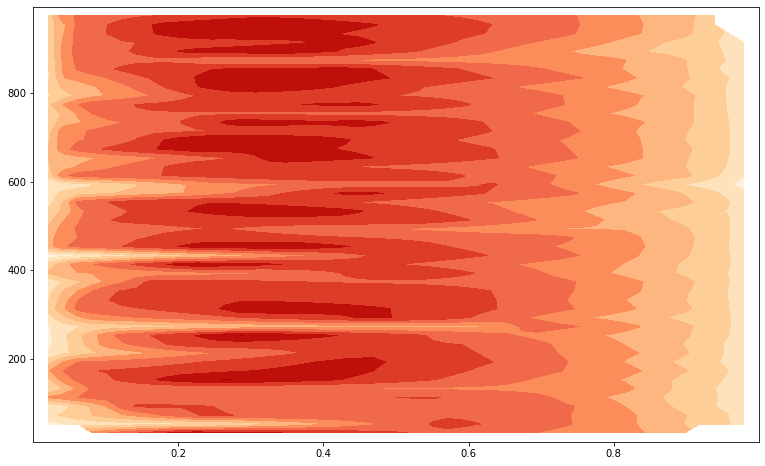

In [259]:
# from https://stackoverflow.com/questions/52935143/how-to-do-a-contour-plot-from-x-y-z-coordinates-in-matplotlib-plt-contourf-or
# could also use https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

from scipy.interpolate import griddata

def plot_contour(x,y,z,resolution = 50,contour_method='linear'):
    resolution = str(resolution)+'j'
    X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method=contour_method)
    return X,Y,Z

X,Y,Z = plot_contour(df_results['contamination'],df_results['n_estimators'],df_results['gm_train'],
                     resolution = 50,
                     contour_method='linear')

with plt.style.context("seaborn-bright"):
    fig, ax = plt.subplots(figsize=(13,8))
#     ax.scatter(df_results['contamination'],df_results['max_samples'], color="black", linewidth=1, edgecolor="ivory", s=50)
    ax.contourf(X,Y,Z,cmap='OrRd', alpha=1)

In [127]:
# choose a set of parameters that got good results, and check results on the train, validation, and test sets
contamination=0.371597
max_samples=64
n_estimators=524

# establish model parameters
clf = IsolationForest(behaviour='new', random_state=rng, 
                      contamination=contamination, 
                      max_samples=max_samples,
                      n_estimators=n_estimators)

# train the model
clf.fit(encoder_train,)

# check the results
# training data
y_pred_train = clf.predict(encoder_train)
roc_train = roc_auc_score(new_y_train, y_pred_train)



# validation data
y_pred_val = clf.predict(encoder_val)
roc_val = roc_auc_score(new_y_val, y_pred_val)

# show the ROC scores and confustion matrix
print('#### Train Data Results ####')
print('ROC score: {:.2%}'.format(roc_train))
print('\nConfusion Matix:')
print(confusion_matrix(new_y_train, y_pred_train))

print('\n#### Validation Data Results ####')
print('ROC score: {:.2%}'.format(roc_val))
print('\nConfusion Matix:')
print(confusion_matrix(new_y_val, y_pred_val))

# # use the best threshold value to make a confusion matrix
# df = create_df_reconstruction(eu_recon_val, y_val, "recon_metric",class_to_remove, threshold_val[1])

# print('\nConfusion Matix:')
# print(confusion_matrix(df['new_class'], df['prediction']))


#### Train Data Results ####
ROC score: 76.43%

Confusion Matix:
[[ 292   38]
 [3959 7151]]

#### Validation Data Results ####
ROC score: 67.64%

Confusion Matix:
[[ 315  345]
 [ 438 3082]]


In [128]:
# test data
y_pred_test = clf.predict(encoder_test)
roc_test = roc_auc_score(new_y_test, y_pred_test)

print('\n#### Test Data Results ####')
print('ROC score: {:.2%}'.format(roc_test))
print('\nConfusion Matix:')
print(confusion_matrix(new_y_test, y_pred_test))



#### Test Data Results ####
ROC score: 79.69%

Confusion Matix:
[[ 329    1]
 [ 887 1313]]


![title](https://miro.medium.com/max/927/1*uR09zTlPgIj5PvMYJZScVg.png)

**IDEAS**

-Try imb-learn, http://imbalanced-learn.org/en/stable/, to use a better metric than ROC